# Assessment for Advanced Data Science
Christian Cabrera, Carl Henrik Ek and Neil D. Lawrence
## **Answers by Radzim Sendyka**

## Setup

Fynesse, Google Drive, Imports, Passwords and Connection

**Fynesse**

---
The python library needed to run the prediction according to the "Access, Assess, Address" standard is hosted on `github.com/Radzim` and is `pip` installable as follows:

```
%pip install git+https://github.com/Radzim/fynesse_rs.git
```

The library is structured according to the *Access, Assess, Address* standard for data science solutions. The three modules are imported as follows:

```
import fynesse_rs.access as access
import fynesse_rs.assess as assess
import fynesse_rs.address as address
```

All code in the above modules is included in this notebook (in text form) for convenience, in the sections they apply to.

**Google Drive**

---
Mounting drive for data access. This is necessary for storing login credentials, and uploading data stored in the `pp-complete.csv` and `open_postcode_geo.csv` files to the SQL server.

```
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive")
```

If you don't want to give this notebook access to your drive, you can skip this part and manually input credentials by overwriting the connection code in Question 1 Task A:
```
user=credentials["username"],
password=credentials["password"],
```

**Installs and imports**

---
Collated here for convenience

```
%pip install --ignore-installed PyYAML
%pip install mysql-connector-python-rf
%pip install osmnx
%pip install mlai
%pip install pandas --upgrade
%pip uninstall --yes matplotlib
%pip install matplotlib==3.1.3
%pip install seaborn
```

*Install errors are possible, particularly with Pandas: 
`TypeError: import_optional_dependency() got an unexpected keyword argument 'errors'`. Best course of action is to restart runtime and run all cells again.*
```
import yaml
import mysql
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
import datetime
from collections import Counter
import statsmodels.api as sm
```

In [1]:
%%capture
%pip install --ignore-installed PyYAML
%pip install mysql-connector-python-rf
%pip install osmnx
%pip install mlai
%pip install pandas --upgrade
%pip uninstall --yes matplotlib
%pip install matplotlib==3.1.3
%pip install seaborn

import mysql.connector
import yaml

In [2]:
%%capture
%pip uninstall fynesse_rs -y
%pip install git+https://github.com/Radzim/fynesse_rs.git
import fynesse_rs.access as access
import fynesse_rs.assess as assess
import fynesse_rs.address as address

In [3]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Question 1. Accessing a Database of House Prices, Latitudes and Longitudes

### Task A

AWS database set up and connection

**ANSWER TO TASK A**

---
Creating the AWS database was challenging due to issues with AWS educate and the limitations of free-tier personal accounts. The database I was able to create using my personal details was inexplicably highly limited in speed (running even up to 10 times slower than other students in comparing the same queries on identical tables) so I recreated the tables again in the AWS database instance provided to us later. This database is sufficient in speed for the task.

---
Credential interact and storage code:

```
@interact_manual(username=Text(description="Username:"), password=Password(description="Password:"))
def write_credentials(username, password):
    with open("credentials.yaml", "w") as file:
        credentials_dict = {'username': username, 'password': password}
        yaml.dump(credentials_dict, file)
```

---
Database connection code:

```
database_details = {"url": 'database-rs2071.cgrre17yxw11.eu-west-2.rds.amazonaws.com', "port": 3306}
with open("credentials.yaml") as file:
  credentials = yaml.safe_load(file)
username = credentials["username"]
password = credentials["password"]
url = database_details["url"]
```
*The database instance used in this notebook is the one provided by Professor Neil Lawrence (in an email dated 17/11/2021). Contact him or me for access credentials.*
```
%sql mariadb+pymysql://$username:$password@$url?local_infile=1
```
```
%sql USE `main`
```



---



Additionally for first setup (`main` used instead of `property_prices`):
```
%sql CREATE DATABASE IF NOT EXISTS `main` DEFAULT CHARACTER SET utf8 COLLATE utf8_bin
```

and to enable `%sql` and `%%sql` commands:
```
%pip install ipython-sql
%pip install PyMySQL
%load_ext sql
```

---
In order to transfer this logic into fynesse the connection logic had to be reworked to use `mysql.connector` instead of `%sql magic`.

This requires the following connection object to be created.
```
connection = mysql.connector.connect(
  host=database_details["url"],
  user=credentials["username"],
  password=credentials["password"],
  database='main'
)
```

In [4]:
database_details = {"url": 'database-rs2071.cgrre17yxw11.eu-west-2.rds.amazonaws.com', "port": 3306}
with open("credentials.yaml") as file:
  credentials = yaml.safe_load(file)

connection = mysql.connector.connect(
  host=database_details["url"],
  user=credentials["username"],
  password=credentials["password"],
  database='main'
)

### Task B

The `pp_data` table

**ANSWER TO TASK B**

---
Step 1: Creating the `pp_data` table

```
DROP TABLE IF EXISTS `pp_data`;
CREATE TABLE IF NOT EXISTS `pp_data` (
  `transaction_unique_identifier` tinytext COLLATE utf8_bin NOT NULL,
  `price` int(10) unsigned NOT NULL,
  `date_of_transfer` date NOT NULL,
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `property_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `new_build_flag` varchar(1) COLLATE utf8_bin NOT NULL,
  `tenure_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `primary_addressable_object_name` tinytext COLLATE utf8_bin NOT NULL,
  `secondary_addressable_object_name` tinytext COLLATE utf8_bin NOT NULL,
  `street` tinytext COLLATE utf8_bin NOT NULL,
  `locality` tinytext COLLATE utf8_bin NOT NULL,
  `town_city` tinytext COLLATE utf8_bin NOT NULL,
  `district` tinytext COLLATE utf8_bin NOT NULL,
  `county` tinytext COLLATE utf8_bin NOT NULL,
  `ppd_category_type` varchar(2) COLLATE utf8_bin NOT NULL,
  `record_status` varchar(2) COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1 ;
```

---
Step 2: Adding keys and indices to the table

```
ALTER TABLE `pp_data`
ADD PRIMARY KEY (`db_id`);
```

```
ALTER TABLE `pp_data`
MODIFY `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,AUTO_INCREMENT=1;
CREATE INDEX `pp.postcode` USING HASH
ON `pp_data`
(postcode);
CREATE INDEX `pp.date` USING HASH
ON `pp_data` 
(date_of_transfer);
```

---
**Q:** Briefly describe what the schema is doing and why we will find it useful to create the indexes we have for the table we've created.

**A:** The schema is setting up the structure of the table so that it can be populated with data in a way that ensures each cell belongs to a correct row whose name we can use to query table information. 

A primary key is added in order to have a way to uniquely identify each row.

Keys on `postcode` and `date_of_transfer` are important to increase the efficiency of queries that search or filter by the values from these columns. This is because by creating an index the server can extract data that matches a condition on an indexed column without having to search through the entire table, and instead quickly get the relevant rows using a binary tree search (as opposed to an O(n) search).

---
Step 3: Populating the table with data.

The data needed for this table was downloaded from `http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-complete.csv` and uploaded into google drive, in order to be able to access the data from google colab. The entire dataset was possible to load at once, so uploading fragmented files was not necessary.

```
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive")
```

This allowed the following query to find the `pp-complete.csv` file and load it into the previously defined `pp_data` table. The code differs slightly from the one given in the worksheet: `LOCAL DATA LOAD` was replaced by `LOAD DATA LOCAL`, and the query was changed to include `OPTIONALLY ENCLOSED by '"'`.

```
LOAD DATA LOCAL INFILE 'pp-complete.csv' INTO TABLE `pp_data`
FIELDS TERMINATED BY ',' OPTIONALLY ENCLOSED by '"'
LINES STARTING BY '' TERMINATED BY '\n';
```



In order to verify the success of the procedure the following queries were run:
*   `SELECT * FROM 'pp_data' LIMIT 10` which verified that the rows were loaded correctly
*   `SELECT COUNT(*) FROM 'pp_data'` which verified that all rows (26 467 225) were loaded into the table

---
*This code is not included in fynesse as it does not need to be re-run*

### Task C

The `postcode_data` table

**ANSWER TO TASK C**

---
Step 1: Creating the `postcode_data` table

```
DROP TABLE IF EXISTS `postcode_data`;
CREATE TABLE IF NOT EXISTS `postcode_data` (
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `status` enum('live','terminated') NOT NULL,
  `usertype` enum('small', 'large') NOT NULL,
  `easting` int unsigned,
  `northing` int unsigned,
  `positional_quality_indicator` int NOT NULL,
  `country` enum('England', 'Wales', 'Scotland', 'Northern Ireland', 'Channel Islands', 'Isle of Man') NOT NULL,
  `lattitude` decimal(11,8) NOT NULL,
  `longitude` decimal(10,8) NOT NULL,
  `postcode_no_space` tinytext COLLATE utf8_bin NOT NULL,
  `postcode_fixed_width_seven` varchar(7) COLLATE utf8_bin NOT NULL,
  `postcode_fixed_width_eight` varchar(8) COLLATE utf8_bin NOT NULL,
  `postcode_area` varchar(2) COLLATE utf8_bin NOT NULL,
  `postcode_district` varchar(4) COLLATE utf8_bin NOT NULL,
  `postcode_sector` varchar(6) COLLATE utf8_bin NOT NULL,
  `outcode` varchar(4) COLLATE utf8_bin NOT NULL,
  `incode` varchar(3)  COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin;
```

---
Step 2: Adding keys and indices to the table

```
ALTER TABLE `postcode_data`
ADD PRIMARY KEY (`db_id`);
```

```
ALTER TABLE `postcode_data`
MODIFY `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,AUTO_INCREMENT=1;
CREATE INDEX `po.postcode` USING HASH
ON `postcode_data`
(postcode);
```

```
CREATE INDEX `postcode.coordinates` USING BTREE
ON `postcode_data`
(`lattitude`, `longitude`);
```

Keys on `postcode`, `lattitude` and `longitude` are important to increase the efficiency of queries that will be searching for postcodes that fit in a certain range of coordinate values. 

---
Step 3: Populating the table with data.

The data needed for this table was downloaded from `https://www.getthedata.com/downloads/open_postcode_geo.csv.zip` and uploaded into google drive, in order to be able to access the data from google colab.

```
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive")
```

This allowed the following query to find the `open_postcode_geo.csv` file and load it into the previously defined `postcode_data` table.

```
LOAD DATA LOCAL INFILE 'open_postcode_geo.csv' INTO TABLE `postcode_data`
FIELDS TERMINATED BY ',' OPTIONALLY ENCLOSED by '"'
LINES STARTING BY '' TERMINATED BY '\n';
```



In order to verify the success of the procedure the following queries were run:
*   `SELECT * FROM `postcode_data` LIMIT 10` which verified that the rows were loaded correctly
*   `SELECT COUNT(*) FROM 'postcode_data'` which verified that all rows (2 581 934) were loaded into the table

---
*This code is not included in fynesse as it does not need to be re-run*

### Task D 

Joining the tables

**ANSWER TO TASK D**

---

In preparation for this task to increase efficiency of the query the following indexes were added, and verified to be present via the `SHOW INDEX FROM :table_name` query:
*   Binary Tree Index on `postcode` in the `pp_data` table
*   Binary Tree Index on `postcode` in the `postcode_data` table

The tables were large in size (`pp_data` 26 467 225 and `postcode` 2 581 934 rows), but an inner join could be performed in reasonable time with the aforementioned indexes.

Issues with stalled queries were monitored and addressed by using the `SHOW FULL PROCESSLIST` and `KILL :query_id` commands.

---
Before joins can be inserted into the database there needs to be a table for them. A `prices_coordinates_data` table is created using the following query:
```
DROP TABLE IF EXISTS `prices_coordinates_data`;
CREATE TABLE IF NOT EXISTS `prices_coordinates_data` (
  `price` int(10) unsigned NOT NULL,
  `date_of_transfer` date NOT NULL,
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `property_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `new_build_flag` varchar(1) COLLATE utf8_bin NOT NULL,
  `tenure_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `locality` tinytext COLLATE utf8_bin NOT NULL,
  `town_city` tinytext COLLATE utf8_bin NOT NULL,
  `district` tinytext COLLATE utf8_bin NOT NULL,
  `county` tinytext COLLATE utf8_bin NOT NULL,
  `country` enum('England', 'Wales', 'Scotland', 'Northern Ireland', 'Channel Islands', 'Isle of Man') NOT NULL,
  `lattitude` decimal(11,8) NOT NULL,
  `longitude` decimal(10,8) NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1;
```
After data has been inserted the table will need to be prepared in order to be able to compute queries efficiently. This will be done by including the relevant indexes:
*   Binary Tree Index on `postcode` in the `prices_coordinates_data` table
*   Binary Tree Index on `date_of_transfer` in the `prices_coordinates_data` table
*   Joined Binary Tree Index on `(lattitude, longitude)` in the `prices_coordinates_data` table
---

Full Join Attempt
```
INSERT INTO `prices_coordinates_data`
SELECT pp.`price`, pp.`date_of_transfer`, cd.`postcode`, pp.`property_type`, pp.`new_build_flag`, pp.`tenure_type`, pp.`locality`, pp.`town_city`, pp.`district`, pp.`county`, cd.`country`, cd.`lattitude`, cd.`longitude`, pp.`db_id`
FROM `pp_data` pp
INNER JOIN `postcode_data` cd
ON (cd.`postcode` = pp.`postcode`)
```

This was likely to be long, but I allowed for that, and estimated the runtime from running this query on a subset of the data (first 1000, 10000, 100000, and 1000000 rows of `pp_data`). The estimations showed that this should be done in 30-60 minutes - for example 1M rows was processed in around 2 minutes.

However, for unknown reasons the code did not complete even when given all of the Google Colab's 12 hours of available runtime.

---
Blockwise Join Attempt

```
INSERT INTO `prices_coordinates_data`
SELECT pp.`price`, pp.`date_of_transfer`, cd.`postcode`, pp.`property_type`, pp.`new_build_flag`, pp.`tenure_type`, pp.`locality`, pp.`town_city`, pp.`district`, pp.`county`, cd.`country`, cd.`lattitude`, cd.`longitude`, pp.`db_id`
FROM (SELECT * FROM `pp_data` LIMIT :start, :end) pp
INNER JOIN `postcode_data` cd
ON (cd.`postcode` = pp.`postcode`)
```
The same join, but done at only a part of the data at a time. Split into chunks of 1M to 4M in size, the operations were going well, at a speed of around 1M/2min until the 8M-12M batch, which unexpectedly stalled for over 1.5 hours and didn't return any results.

---
In conclusion, something in the database is not working correctly, and this approach is not possible at this time. 

---
Instead, for the purposes of this assessment, the operations on will be done by first querying the postcodes which lie in a given coordinate range, and then querying the transactions from those postcodes.

The query sent to the database is as follows:

```
  SELECT a_t.`date_of_transfer`, pcd.`postcode`, pcd.`lattitude`, pcd.`longitude`, a_t.`property_type`, a_t.`price` FROM
  (SELECT `postcode`, `date_of_transfer`, `property_type`, `price` FROM `pp_data`
  WHERE `postcode` IN 
  (SELECT `postcode` from `postcode_data`
  WHERE `lattitude` BETWEEN :lat_0 AND :lat_1
  AND `longitude` BETWEEN :lon_0 AND :lon_1)
  AND `date_of_transfer` BETWEEN :date_0 AND :date_1
  AND `property_type` = :prop_type) a_t
  INNER JOIN
  `postcode_data` pcd
  ON (pcd.`postcode`= a_t.`postcode`)
```

lat_0, lat_1, lon_0, lon_1, date_0, date_1 and property_type are variables that are pre-calculated and passed to the function that calls the query. Another version of the function does the same but without any parameters for `date_of_transfer` and `property_type`.

---
Code to calculate the bounding box for longitude, la*tt*itude and date_of_transfer (in both versions - with date and type or without):

```
def distance(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * asin(sqrt(a))

def get_box(location, range_km):
  reference_point = (52, 0)
  latitude_angle_to_km = distance(reference_point[0]-0.5, reference_point[1], reference_point[0]+0.5, reference_point[1])
  longitude_angle_to_km = distance(reference_point[0], reference_point[1]-0.5, reference_point[0], reference_point[1]+0.5)
  box_lat = range_km/latitude_angle_to_km
  box_lon = range_km/longitude_angle_to_km
  return location[1]-box_lon/2, location[1]+box_lon/2, location[0]-box_lat/2, location[0]+box_lat/2

def get_house_prices(location, date, range_km, range_years, property_type):
  lon_0, lon_1, lat_0, lat_1 = get_box(location, range_km)
  datetime_object = datetime.datetime.fromisoformat(date)
  timedelta_object = datetime.timedelta(days=range_years*365//2)
  date_0, date_1 = str(datetime_object-timedelta_object)[:10], str(datetime_object+timedelta_object)[:10]
  return get_house_prices_inner(lat_0, lat_1, lon_0, lon_1, date_0, date_1, property_type)

def get_house_prices_all(location, date, range_km, range_years, property_type):
  lon_0, lon_1, lat_0, lat_1 = get_box(location, range_km)
  datetime_object = datetime.datetime.fromisoformat(date)
  timedelta_object = datetime.timedelta(days=range_years*365//2)
  date_0, date_1 = str(datetime_object-timedelta_object)[:10], str(datetime_object+timedelta_object)[:10]
  return get_house_prices_all_inner(lat_0, lat_1, lon_0, lon_1)
```

These functions call an inner function that is only used to pass the query to the SQL server using the query mentioned earlier.

```
def get_house_prices_inner(lat_L, lat_H, lon_L, lon_H, date_L, date_H, prop_type):
  hp = %sql SELECT a_t.`date_of_transfer`, pcd.`postcode`, pcd.`lattitude`, pcd.`longitude`, a_t.`property_type`, a_t.`price` FROM (SELECT `postcode`, `date_of_transfer`, `property_type`, `price` FROM `pp_data` WHERE `postcode` IN  (SELECT `postcode` from `postcode_data` WHERE `lattitude` BETWEEN :lat_L AND :lat_H AND `longitude` BETWEEN :lon_L AND :lon_H) AND `date_of_transfer` BETWEEN :date_L AND :date_H  AND `property_type` = :prop_type) a_t INNER JOIN `postcode_data` pcd ON (pcd.`postcode`= a_t.`postcode`)
  return hp

def get_house_prices_all_inner(lat_L, lat_H, lon_L, lon_H):
  hp = %sql SELECT a_t.`date_of_transfer`, pcd.`postcode`, pcd.`lattitude`, pcd.`longitude`, a_t.`property_type`, a_t.`price` FROM (SELECT `postcode`, `date_of_transfer`, `property_type`, `price` FROM `pp_data` WHERE `postcode` IN  (SELECT `postcode` from `postcode_data` WHERE `lattitude` BETWEEN :lat_L AND :lat_H AND `longitude` BETWEEN :lon_L AND :lon_H)) a_t INNER JOIN `postcode_data` pcd ON (pcd.`postcode`= a_t.`postcode`)
  return hp
```
 In order to transfer this logic into fynesse the last two functions had to be reworked to use `mysql.connector` instead of `%sql magic`.

```
def get_house_prices_inner(connection, lat_L, lat_H, lon_L, lon_H, date_L, date_H, prop_type):
  curr = connection.cursor(buffered=True)
  query = """
  SELECT a_t.`date_of_transfer`, pcd.`postcode`, pcd.`lattitude`, pcd.`longitude`, a_t.`property_type`, a_t.`price` FROM
  (SELECT `postcode`, `date_of_transfer`, `property_type`, `price` FROM `pp_data`
  WHERE `postcode` IN 
  (SELECT `postcode` from `postcode_data`
  WHERE `lattitude` BETWEEN {lat_0} AND {lat_1}
  AND `longitude` BETWEEN {lon_0} AND {lon_1})
  AND `date_of_transfer` BETWEEN {date_0} AND {date_1}
  AND `property_type` = {prop_type})) a_t
  INNER JOIN
  `postcode_data` pcd
  ON (pcd.`postcode`= a_t.`postcode`)
  """
  query=query.format(lat_0=lat_L, lat_1=lat_H, lon_0=lon_L, lon_1=lon_H, date_0=date_L, date_1=date_H, prop_type=prop_type)
  curr.execute(query)
  return curr.fetchall()

def get_house_prices_all_inner(connection, lat_L, lat_H, lon_L, lon_H):
  curr = connection.cursor(buffered=True)
  query = """
  SELECT a_t.`date_of_transfer`, pcd.`postcode`, pcd.`lattitude`, pcd.`longitude`, a_t.`property_type`, a_t.`price` FROM
  (SELECT `postcode`, `date_of_transfer`, `property_type`, `price` FROM `pp_data`
  WHERE `postcode` IN 
  (SELECT `postcode` from `postcode_data`
  WHERE `lattitude` BETWEEN {lat_0} AND {lat_1}
  AND `longitude` BETWEEN {lon_0} AND {lon_1})) a_t
  INNER JOIN
  `postcode_data` pcd
  ON (pcd.`postcode`= a_t.`postcode`)
  """
  query=query.format(lat_0=lat_L, lat_1=lat_H, lon_0=lon_L, lon_1=lon_H)
  curr.execute(query)
  return curr.fetchall()
```

---
This approach is highly efficient, and substantially faster than the OSM part of the assignment, and will therefore not be a significant performance bottleneck.

---
***This code is included in the access.py module***


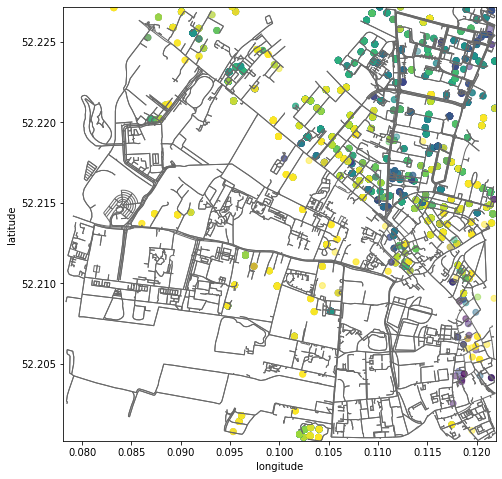

In [5]:
access.show_house_prices(connection, (52.2137, 0.1), 3)

## Question 2. Accessing OpenStreetMap and Assessing the Available Features


**ANSWER TO QUESTION 2**

---
The following functions are used to connect with Open Street Maps and get the relevant information for a given location and range. `get_pois` returns a list of all relevant objects in that area, `concise_pois` modifies the data to include columns for `latitude` and `longitude` and `get_pois_counts` returns the counts of the kinds of the objects.

```
def get_pois(location, range_km, tag='amenity'):
    tags = {tag: True}
    lon_0, lon_1, lat_0, lat_1 = access.get_box(location, range_km)
    places = ox.geometries_from_bbox(lat_1, lat_0, lon_1, lon_0, tags)
    return places


def concise_pois(places, tag='amenity'):
    geometries = places['geometry']
    longitudes = []
    latitudes = []
    for geometry in geometries:
        latitudes.append(geometry.centroid.y)
        longitudes.append(geometry.centroid.x)
    places['latitude'] = latitudes
    places['longitude'] = longitudes
    return places[[tag, 'latitude', 'longitude']]


def get_pois_counts(pois_df, tag='amenity'):
    return Counter(pois_df[[tag]])
```

These take advantage of the `get_box(location, range_km)` function defined in the previous part of the assignment.

The set of tags queried can be modified in order to find the most informative ones.

---
***This code is included in the assess.py module***

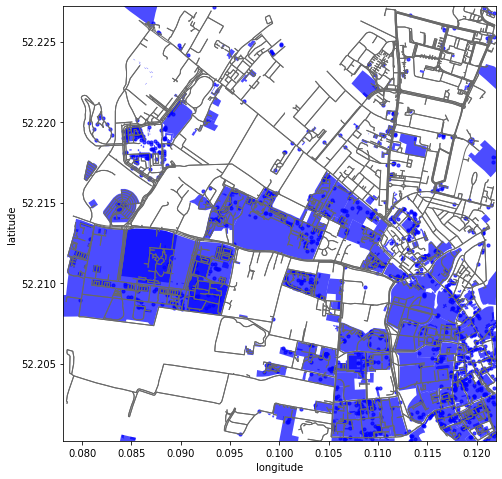

In [6]:
assess.show_pois((52.2137, 0.1), 3)

*Install errors are possible, particularly with Pandas: 
`TypeError: import_optional_dependency() got an unexpected keyword argument 'errors'`. Best course of action is to restart runtime and run all cells again.*

**COMBINING QUESTION 1 AND QUESTION 2**

---
In order to apply a linear model to the data it has to be structured appropriately. The code below combines the Open Street Maps data with the property price data, by looking up all points of interest close to every address inside a given distance, and returning counts of potential objects.

```
def prepare_dataframe_for_prediction(house_prices_df, pois_df, amenity_distance, all_possible_pois):
    columns = ['price', 'date_of_transfer', 'property_type', 'lattitude', 'longitude']
    house_prices_df_important = house_prices_df[columns]
    if len(pois_df) == 0:
        house_prices_df_important['pois_nearby'] = {}
        return house_prices_df_important
    pois_concise = concise_pois(pois_df)
    house_prices_df_important['pois_nearby'] = house_prices_df_important.apply(
        lambda row: find_pois_within((row['lattitude'], row['longitude']), amenity_distance, pois_concise, all_possible_pois), axis=1)
    return house_prices_df_important

def find_pois_within(location, range_km, pois_concise, all_possible_pois):
    lon_0, lon_1, lat_0, lat_1 = access.get_box(location, range_km)
    pois_in_range = pois_concise.loc[(pois_concise['longitude'] >= lon_0) & (pois_concise['longitude'] <= lon_1) & (pois_concise['latitude'] >= lat_0) & (pois_concise['latitude'] <= lat_1)]
    counts = Counter(pois_in_range[['amenity']].values.reshape(-1, ).tolist() + list(all_possible_pois))
    [counts.update({k: -1}) for k in counts.keys()]
    return counts
```
---
***This code is included in the assess.py module***

## Question 3. Addressing a Property Price Prediction Question

The prediction function takes input of `latitude, longitude, date, property_type`, where `latitude` and `longitude` represent the coordinates of the house whose price we want to predict, `date` represents the time at which we want to predict the price (formatted as `'YYYY-MM-DD'`), and `property_type` represents the type of the property whose price we want to predict (`'F'` - flat, `'S'` - semidetached, `'D'` - detached, `'T'` - terraced, `'O'` - other).

Additionally, it requires an SQL connection object (see Question 1 Task A), and three optional arguments that change the scope of the data used for prediction: `box_size` - size of the range from which properties are looked up (in km), `box_years` - the time range from which properties are looked up (in years), `amenity_distance` -  the range in which OSM points of interest are looked up for each property (in km). The default values for these arguments are `box_size=3, box_years=3, amenity_distance=0.5`.

*These ranges refer to the box size, not radius: i.e. box_size=3 refers to a 3km by 3km square around the location, not 6km x 6km, and box_years=3 refers to a time period of 3 years, not 6 years.*

Choosing a bounding box size is a balancing act between variance and accuracy. Stricter criteria means higher accuracy, but also higher variance, whereas more permissive criteria that returns more data leads to more accurate predictions that may be suffering from huge variance.

```
def predict_price(latitude, longitude, date, property_type, connection=None, amenities=None, box_size=3, box_years=3, amenity_distance=0.5):
    if connection is None:
        return 'No SQL connection found'
```
In order to work with Linear Models the `date` value has to be converted to a numerical values - here they are converted to the number of days since January 1st 1970.
```
    dt = datetime.datetime.fromisoformat(date)
    epoch = datetime.datetime.utcfromtimestamp(0)
    date_as_int = int((dt - epoch).total_seconds() / 24 / 60 / 60)
```
Code from `fynesse_rs.access` is called to return appropriately formated house price data from the region, time and property type specified. If few houses (`< 100`) are found a warning is printed in order to let the user know that the bounding criteria they used may be too strict to allow for a good prediction. If no houses are found, the function returns an error - the user should increase bounding criteria or examine their criteria for errors.
```
    house_prices_df = access.get_house_prices(connection, (latitude, longitude), date, box_size, box_years, property_type)
    if house_prices_df.shape[0] == 0:
        return 'ERROR: found no houses in that area'
    if house_prices_df.shape[0] < 100:
        print 'WARNING: not enough houses for a good prediction (' + str(house_prices_df.shape[0]) + ')'
```
Code from `fynesse_rs.assess` is called to return the relevant OSM data from the region. The data is later formatted using `pois_concise`, and a helper  list of all possible points of interest is calculated. The counts of points of interest local to the prediction location are also calculated in order to enable making a prediction.
```
    pois_df = assess.get_pois((latitude, longitude), box_size)
    pois_concise = assess.concise_pois(pois_df)

    if amenities is None:
    all_possible_pois = []
    # all_possible_pois = set(pois_concise[['amenity']].values.reshape(-1, ).tolist())
else:
    all_possible_pois = amenities

    all_possible_pois = set(pois_concise[['amenity']].values.reshape(-1, ).tolist())
    local_pois = assess.find_pois_within((latitude, longitude), amenity_distance, pois_concise, all_possible_pois)
    local_pois = list(pd.Series(local_pois))
```
You may notice a commented out line here: in a previous version of the code it was default to consider all available amenities, but a design with ~50 columns almost always resulted in highly overfit results (typical R value was around `0.97`, but predictions terrible), so the default was changed to using no amenities. To include amenities in the prediction set the argument `amenities` in the function call, for example: `amenities=['parking', 'hospital', 'school']`. 

*A list of all amenities available in OpenStreetMaps: `https://wiki.openstreetmap.org/wiki/Key:amenity`*

Numbers of elements in the two dataframes are printed to give an idea of the quality of the future prediction (low number of houses is likely to return a bad model, and no houses will not return a valid prediction), and the time that the computation might take.
```
    print('Number of houses:', len(house_prices_df))
    print('Number of pois:', len(pois_df))
```
The two dataframes are joined using code from the `fynesse_rs.assess` module, and converted into a format that will allow a linear model to make predictions - the counts of each present type of OSM point are moved to separate columns.
```
    house_data = assess.prepare_dataframe_for_prediction(house_prices_df, pois_df, amenity_distance)
    house_data['date_of_transfer'] = pd.to_datetime(house_data['date_of_transfer']).astype(int) / 10 ** 9 / 24 / 60 / 60
    house_data = house_data.drop('property_type', 1)
    pois_data = house_data['pois_nearby'].apply(pd.Series)
    house_data = house_data.drop('pois_nearby', 1)
```
The data is applied to an OLS model. The y-axis represents time, and the x-axis/given values are 'date_of_transfer', 'lattitude', 'longitude', and the counts of points of interest.

Data about the Prediction Basis and OLS Regression Results are printed out to give the user information about the quality of the prediction.
```
    y = house_data[['price']].values
    design = np.concatenate((house_data[['date_of_transfer', 'lattitude', 'longitude']].values, pois_data.values),axis=1)
    m_linear_basis = sm.OLS(y, design)
    results_basis = m_linear_basis.fit()
    print('Prediction basis', results_basis.summary())
```

The resulting model is validated by using 10 randomly chosen houses in the region, and comparing the prices predicted for them to the actual ones.
```
    actual_values, predicted_values = [], []
    for i in range(25):
        row_number = random.randint(0, len(house_prices_df)-1)
        actual_values.append(y[row_number][0])
        valid_date, valid_latitude, valid_longitude = house_data[['date_of_transfer', 'lattitude', 'longitude']].values[row_number]
        valid_local_pois = assess.find_pois_within((valid_latitude, valid_longitude), amenity_distance, pois_concise, all_possible_pois)
        valid_local_pois = list(pd.Series(valid_local_pois))
        y_pred_linear_valid = results_basis.get_prediction([valid_date, valid_latitude, valid_longitude] + valid_local_pois).summary_frame(alpha=0.05)
        predicted_values.append(int(y_pred_linear_valid['mean'].values[0]))
    print('Validation:\n', actual_values, '\n', predicted_values)
    print('Mean error:', str(round(mean(abs(x - y)/max(x, y) for x, y in zip(actual_values, predicted_values))*100, 2))+'%')

```
Code to print potential warnings about the prediction quality:
```
    if mean(abs(x - y)/max(x, y) for x, y in zip(actual_values, predicted_values)) > 0.5:
        print('WARNING: High mean error ('+str(round(mean(abs(x - y)/max(x, y) for x, y in zip(actual_values, predicted_values))*100, 2))+'%)')
    print('Correlation:', str(round(np.corrcoef(actual_values, predicted_values)[0][1], 2))+'%')
    if np.corrcoef(actual_values, predicted_values)[0][1] < 0.3:
        print('WARNING: Low correlation ('+str(round(np.corrcoef(actual_values, predicted_values)[0][1], 2))+'%'+')')
   
```

The last part of the function applies the data about the point to make a prediction - date, latitude, longitude (given as arguments) and the list of local points of interest as calculated previously.

The prediction properties (` mean       mean_se  ...   obs_ci_lower   obs_ci_upper`) are printed to give the user further data about the quality of the prediction.
```
    y_pred_linear = results_basis.get_prediction([date_as_int, latitude, longitude]+local_pois).summary_frame(alpha=0.05)
    print('Prediction:\n', y_pred_linear)
    print('Prediction value:', y_pred_linear['mean'].values[0])
    print('Prediction std err:', y_pred_linear['mean_se'].values[0])
    return y_pred_linear['mean'].values[0]
```
The function returns a number that represents the predicted value (or an error in case of too few data points).

---
At the end the fuction shows a plot visualising the correlation between sample predicted values of homes and their actual prices.

It is recommended to run the `assess.show_pois()` and `access.show_house_prices()` functions in order to better visualise the relevant house price and OSM data.

---
***This code is included in the address.py module***

Number of houses: 57
Number of pois: 1652


-----------------




/usr/local/lib/python3.7/dist-packages/fynesse_rs/address.py:43: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  house_data['date_of_transfer'] = pd.to_datetime(house_data['date_of_transfer']).astype(int) / 10 ** 9 / 24 / 60 / 60
/usr/local/lib/python3.7/dist-packages/fynesse_rs/address.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  house_data = house_data.drop('property_type', 1)
/usr/local/lib/python3.7/dist-packages/fynesse_rs/address.py:46: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  house_data = house_data.drop('pois_nearby', 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigva

Prediction basis                                  OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.963
Model:                            OLS   Adj. R-squared (uncentered):              0.959
Method:                 Least Squares   F-statistic:                              270.1
Date:                Thu, 02 Dec 2021   Prob (F-statistic):                    6.32e-36
Time:                        18:29:15   Log-Likelihood:                         -720.74
No. Observations:                  57   AIC:                                      1451.
Df Residuals:                      52   BIC:                                      1462.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------

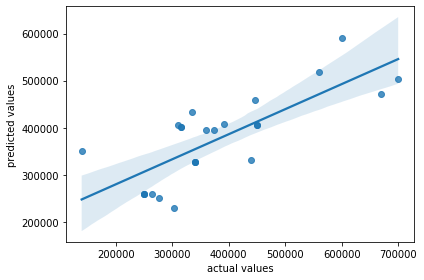

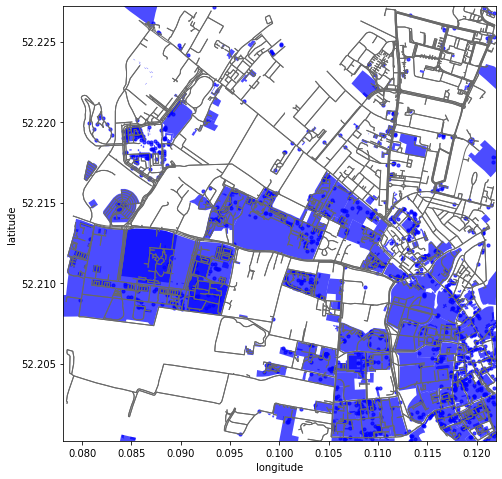

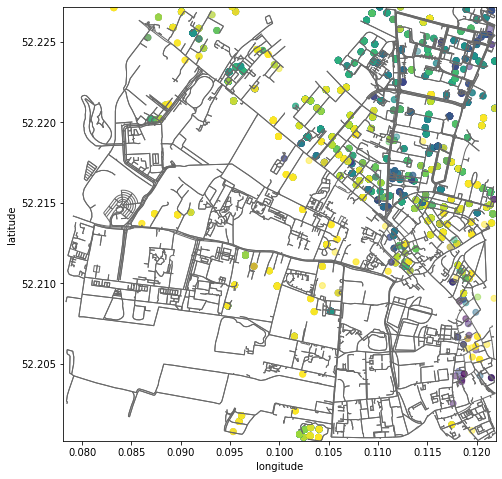

In [7]:
# Flat around Churchill College, on the date of our deadline
address.predict_price(52.2137, 0.1, '2021-12-03', 'F', connection=connection, amenities=['parking', 'hospital', 'university'])
assess.show_pois((52.2137, 0.1), 3)
access.show_house_prices(connection, (52.2137, 0.1), 3)

*Install errors are possible, particularly with Pandas: 
`TypeError: import_optional_dependency() got an unexpected keyword argument 'errors'`. Best course of action is to restart runtime and run all cells again.*

#### Practical 4

**Test Predictions**

---

1.   Flat, 2002, 50.770, 0.130
         predicted price: 110547
2.   Detached, 2015, 51.381, -0.254
         predicted price: 603608
3.   Semidetached, 1999, 53.357, -1.489
         predicted price: 85396
4.   Other, 2012, 53.400, -1.741
         predicted price: 1034625 (with 10km box - only 3 houses)
                          517351 (with 20km box)

Due to the discrepancy with input data format, the year given was interpreted as "middle of the year" and set to July 1st (`YYYY-07-01`).

The last location (`Other, 2012, 53.400, -1.741`) is a place in the middle of the woods so the standard `box_size=3` is too small to return any results. It was increased to:
*   10km - few data points (just 3) but closer to location
*   20km - many data points but further from location

*Note: due to small changes to the code made between the tick session and hand-in, the exact values of these predictions may slightly vary if rerun now.*

#### Discussion of model

The data used for prediction is time, latitude, and longitude, as well as a list of amenities around each house.

These are all used only in linear functions, as for such small sizes more complex models were overfitting the data and returning some very unrealistic results.

The results are very good, with the validation mean error usually within `20%` of the value, and a high correlation (usually `40%` to `80%`), which is very promising since that is a correlation only within a sample of already very similar houses, where even a correlation of 0% would be a rather good "regional average" predictor. Positive correlation values prove that the model is much better than a simple regional average calculation. The model is not complex enough to warrant concerns of overfitting.

If the range of houses was much larger, a more complex model could be needed to better reflect the regional price variations. However, such predictions would not be feasible due to the time it would take to gather the necessary data from SQL and OSM.

A limitation of the system is that OSM does not contain historical data, so the model is likely to be less accurate for earlier transactions that happened when the points of interest in the region differed significantly from the current state as returned by OSM.

The prices of houses of type `other` are not a good predictor for values of other houses of type `other`. This is because the type does not refer to a particular type of structure, but to all the outliers. Both a hospital and a shed could be included in type `other`, and basing the price prediction of a hospital on the price of the shed is not likely to yield any good results. When trying to predict the value of a house that does not fit any other type, it is more useful to input the type of house that is closest, rather than picking `other`.

#### Technical Notes

*   The notebook is structures in a way that `Run All` can be applied to it to get all necessary imports, values, and objects ready.
*   In particular, you need to run the 4 cells in "Setup" and 1 cell in "Question 1 Part A" in order to be able to run predictions.
*   Install errors are possible, particularly with `Pandas` and `Yaml`. Best course of action is to restart runtime and run all cells again.
*   Database creation and file upload codes were only included in text form as they do not need to be rerun, and an accidental run of that code would be likely to cause issues with the database.
*   Some SQL code snippets included in this notebook exchange $`$ for $'$ in order to work with the notebook markdown.
*   A typo in the word `lattitude` is present in the SQL database, and queries must contain the same typo.
*   `%%capture` prevents text output where it isn't necessary (install code, warnings).

In [8]:
print (r"""
    _        ____      ____     
U  /"\  u   |  _"\    / __"| u  
 \/ _ \/   /| | | |  <\___ \/   
 / ___ \   U| |_| |\  u___) |   
/_/   \_\   |____/ u  |____/>>  
 \\    >>    |||_      )(  (__) 
(__)  (__)  (__)_)    (__)      
""")


    _        ____      ____     
U  /"\  u   |  _"\    / __"| u  
 \/ _ \/   /| | | |  <\___ \/   
 / ___ \   U| |_| |\  u___) |   
/_/   \_\   |____/ u  |____/>>  
 \\    >>    |||_      )(  (__) 
(__)  (__)  (__)_)    (__)      

